In [ ]:
### TSK 2

## ETL Task – Extract Step

import pandas as pd

# -------------------------------
# Step 1: Load the CSV file into a pandas DataFrame
# -------------------------------
# Replace 'OnlineRetail.csv' with the actual path where your file is stored
df = pd.read_csv('Online Retail.csv', encoding='ISO-8859-1')

# -------------------------------
# Step 2: View basic information about the data
# -------------------------------
# This helps you understand column names, data types, and if any data is missing
print("Initial Data Information:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

# -------------------------------
# Step 3: Handle missing values
# -------------------------------
# For this dataset, CustomerID often has missing values, which we may want to drop(because it's difficult to analyze customer behavior without an ID)
df = df.dropna(subset=['CustomerID'])

# -------------------------------
# Step 4: Ensure correct data types
# -------------------------------
# Convert InvoiceDate to datetime format for proper time-based analysis
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Ensure numerical columns are correct type
df['Quantity'] = df['Quantity'].astype(int)
df['UnitPrice'] = df['UnitPrice'].astype(float)

# -------------------------------
# Step 5: Verify the cleaned DataFrame
# -------------------------------
print("\nCleaned Data Information:")
print(df.info())
print("\nSample after cleaning:")
print(df.head())



Initial Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

First 5 rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE     

# ETL Task – Extraction Step

**Objective:** Load the Online Retail dataset into a pandas DataFrame, handle missing values, and ensure correct data types for further processing.

---

### Steps

1. **Import libraries**  
We use `pandas` for data manipulation.
2. **Load the CSV**  
Reads the dataset into a DataFrame.  
`ISO-8859-1` encoding is used to handle special characters in product descriptions.
3. **Inspect the data**  
Check the number of rows and columns, identify missing values and data types, and preview sample rows.
4. **Handle missing values**  
Drops rows where `CustomerID` is missing (critical for customer-based analysis).  
Other missing columns could optionally be filled with default values if needed.
5. **Convert `InvoiceDate` to datetime**  
Converts text dates into proper datetime objects.  
`errors='coerce'` converts invalid or unparseable dates to `NaT`.  
Rows with invalid dates are dropped.
6. **Ensure numerical columns are correct**  
Converts `Quantity` and `UnitPrice` to numeric types. Invalid values are replaced with `0`.
7. **Verify cleaned DataFrame**  
Confirms that all columns have correct data types and missing critical data is removed.

**Result:**  
A clean and structured DataFrame, ready for the **Transform** step: calculating total sales, filtering dates, and preparing for database loading.


In [21]:
## ETL Task – Transform Step

import pandas as pd

# -------------------------------
# Assume df is already the cleaned DataFrame from Extraction step
# -------------------------------

# 1. Remove outliers
# Remove rows with Quantity < 0 or UnitPrice <= 0
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# 2. Calculate TotalSales
# New column = Quantity * UnitPrice
df['TotalSales'] = df['Quantity'] * df['UnitPrice']
# Add Category column
df['Category'] = df['Description'].apply(assign_category)


# 3. Create customer summary (dimension-like extract)
# Group by CustomerID to calculate total purchases, number of orders, and store the country
customer_summary = df.groupby('CustomerID').agg(
    TotalPurchases=('TotalSales', 'sum'),
    NumOrders=('InvoiceNo', 'nunique'),
    Country=('Country', 'first')  # Assumes each customer has a single country
).reset_index()

print("Customer Summary Sample:")
print(customer_summary.head())

# 4. Filter data for sales in the last year
# Assume current date is August 12, 2025
current_date = pd.Timestamp('2025-08-12')
one_year_ago = current_date - pd.DateOffset(years=1)

df_last_year = df[df['InvoiceDate'] >= one_year_ago]

print("\nData after filtering for last year:")
print(df_last_year.shape)
print(df_last_year.head())

# Optional: ready for loading into database
# df_last_year -> Fact table (SalesFact)
# customer_summary -> Dimension table (CustomerDim)


Customer Summary Sample:
   CustomerID  TotalPurchases  NumOrders         Country
0     12346.0        77183.60          1  United Kingdom
1     12347.0         4310.00          7         Iceland
2     12348.0         1797.24          4         Finland
3     12349.0         1757.55          1           Italy
4     12350.0          334.40          1          Norway

Data after filtering for last year:
(0, 10)
Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, TotalSales, Category]
Index: []


In [ ]:
# Define a function to assign categories
def assign_category(desc):
    desc = str(desc).lower()
    if 'phone' in desc or 'tablet' in desc or 'electronic' in desc:
        return 'Electronics'
    elif 'book' in desc:
        return 'Books'
    elif 'chair' in desc or 'table' in desc:
        return 'Furniture'
    else:
        return 'Other'
# Update sales_fact before loading
sales_fact = df_last_year[['InvoiceNo', 'StockCode', 'Description', 'Quantity',
                           'UnitPrice', 'TotalSales', 'CustomerID', 'InvoiceDate', 'Category']]


# ETL Task – Transform Step

**Objective:** Transform the cleaned data by calculating total sales, summarizing customers, filtering by date, and removing outliers.
2. **Calculate TotalSales**  
We create a new column `TotalSales` as `Quantity * UnitPrice` for each row.
3. **Create customer summary (dimension-like extract)**  
We group by `CustomerID` to calculate total purchases and store the customer's country.
4. **Filter data for sales in the last year**  
We assume the current date is August 12, 2025, and filter for invoices from the last year.


In [23]:
import sqlite3
import pandas as pd

# -------------------------------
# Assume df_last_year is the fact table data from Transform step
# and customer_summary is the CustomerDim
# -------------------------------

# 1. Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('retail_dw.db')
cursor = conn.cursor()

# -------------------------------
# 2. Create tables
# -------------------------------

# Customer Dimension
cursor.execute('''
CREATE TABLE IF NOT EXISTS CustomerDim (
    CustomerID INTEGER PRIMARY KEY,
    Country TEXT,
    TotalPurchases REAL,
    NumOrders INTEGER
)
''')

# Time Dimension
cursor.execute('''
CREATE TABLE IF NOT EXISTS TimeDim (
    InvoiceDate TEXT PRIMARY KEY,
    Year INTEGER,
    Month INTEGER,
    Day INTEGER
)
''')

# Sales Fact Table
cursor.execute('''
CREATE TABLE IF NOT EXISTS SalesFact (
    InvoiceNo TEXT,
    StockCode TEXT,
    Description TEXT,
    Quantity INTEGER,
    UnitPrice REAL,
    TotalSales REAL,
    CustomerID INTEGER,
    InvoiceDate TEXT,
    FOREIGN KEY(CustomerID) REFERENCES CustomerDim(CustomerID),
    FOREIGN KEY(InvoiceDate) REFERENCES TimeDim(InvoiceDate)
)
''')

conn.commit()

# -------------------------------
# 3. Populate CustomerDim
# -------------------------------
customer_summary.to_sql('CustomerDim', conn, if_exists='replace', index=False)

# -------------------------------
# 4. Populate TimeDim
# -------------------------------
# Extract Year, Month, Day from InvoiceDate
time_dim = df_last_year[['InvoiceDate']].drop_duplicates().copy()
time_dim['Year'] = time_dim['InvoiceDate'].dt.year
time_dim['Month'] = time_dim['InvoiceDate'].dt.month
time_dim['Day'] = time_dim['InvoiceDate'].dt.day

time_dim.to_sql('TimeDim', conn, if_exists='replace', index=False)

# -------------------------------
# 5. Populate SalesFact
# -------------------------------
# Keep only necessary columns for the fact table
sales_fact = df_last_year[['InvoiceNo', 'StockCode', 'Description', 'Quantity',
                           'UnitPrice', 'TotalSales', 'CustomerID', 'InvoiceDate']]

sales_fact.to_sql('SalesFact', conn, if_exists='replace', index=False)

# -------------------------------
# 6. Verify tables
# -------------------------------
print("CustomerDim sample:")
print(pd.read_sql('SELECT * FROM CustomerDim LIMIT 5', conn))

print("\nTimeDim sample:")
print(pd.read_sql('SELECT * FROM TimeDim LIMIT 5', conn))

print("\nSalesFact sample:")
print(pd.read_sql('SELECT * FROM SalesFact LIMIT 5', conn))

# Close connection
conn.close()


CustomerDim sample:
   CustomerID  TotalPurchases  NumOrders         Country
0     12346.0        77183.60          1  United Kingdom
1     12347.0         4310.00          7         Iceland
2     12348.0         1797.24          4         Finland
3     12349.0         1757.55          1           Italy
4     12350.0          334.40          1          Norway

TimeDim sample:
Empty DataFrame
Columns: [InvoiceDate, Year, Month, Day]
Index: []

SalesFact sample:
Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, UnitPrice, TotalSales, CustomerID, InvoiceDate]
Index: []


# ETL Task – Load Step

**Objective:** Load the transformed data into a SQLite database (retail_dw.db) with a fact table and dimension tables.
1. **Connect to SQLite**  
We create (or connect to) the database file and establish a cursor to execute SQL commands.
2. **Create Dimension and Fact Tables**  
CustomerDim: Stores customer details and aggregated purchase information.
TimeDim: Stores unique invoice dates and extracts Year, Month, Day.
SalesFact: Stores individual sales transactions linking to customers and dates.
3. **Populate CustomerDim**  
We load the customer_summary DataFrame into the CustomerDim table using to_sql.
4. **Populate TimeDim**
Extract Year, Month, Day from InvoiceDate in the transformed fact data (df_last_year).
Load the resulting table into TimeDim.
5. **Populate SalesFact**
Keep only necessary columns (InvoiceNo, StockCode, Description, Quantity, UnitPrice, TotalSales, CustomerID, InvoiceDate)
Load them into SalesFact.
6. **Verify tables**
Preview a few rows from each table to ensure the data has been loaded correctly.

In [26]:
import pandas as pd
import sqlite3

def perform_etl_with_category(csv_path='OnlineRetail.csv', db_path='retail_dw.db', current_date='2025-08-12'):
    """
    Full ETL process with Category column:
    - Extracts data from CSV
    - Transforms data: cleaning, TotalSales, customer summary, last-year filter, add Category
    - Loads into SQLite (SalesFact, CustomerDim, TimeDim)
    - Logs row counts at each stage
    """
    print("=== ETL Process Started ===\n")
    
    # -------------------------------
    # 1. Extraction
    # -------------------------------
    df = pd.read_csv(csv_path, encoding='ISO-8859-1')
    print(f"Rows in raw CSV: {df.shape[0]}")
    
    df = df.dropna(subset=['CustomerID'])
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
    df = df.dropna(subset=['InvoiceDate'])
    df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce').fillna(0).astype(int)
    df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce').fillna(0.0).astype(float)
    print(f"Rows after cleaning: {df.shape[0]}")
    
    # -------------------------------
    # 2. Transformation
    # -------------------------------
    df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
    df['TotalSales'] = df['Quantity'] * df['UnitPrice']
    
    # Add Category column
    def assign_category(desc):
        desc = str(desc).lower()
        if 'phone' in desc or 'tablet' in desc or 'electronic' in desc:
            return 'Electronics'
        elif 'book' in desc:
            return 'Books'
        elif 'chair' in desc or 'table' in desc:
            return 'Furniture'
        else:
            return 'Other'
    
    df['Category'] = df['Description'].apply(assign_category)
    
    # Customer summary (CustomerDim)
    customer_summary = df.groupby('CustomerID').agg(
        TotalPurchases=('TotalSales', 'sum'),
        NumOrders=('InvoiceNo', 'nunique'),
        Country=('Country', 'first')
    ).reset_index()
    print(f"Number of customers: {customer_summary.shape[0]}")
    
    # Filter last-year sales
    current_date = pd.Timestamp(current_date)
    one_year_ago = current_date - pd.DateOffset(years=1)
    df_last_year = df[df['InvoiceDate'] >= one_year_ago]
    
    # Safety: if no rows, use all data
    if df_last_year.shape[0] == 0:
        print("No sales found for last year. Loading all available data instead.")
        df_last_year = df.copy()
    
    print(f"Rows to load (SalesFact): {df_last_year.shape[0]}")
    
    # -------------------------------
    # 3. Load into SQLite
    # -------------------------------
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # CustomerDim
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS CustomerDim (
        CustomerID INTEGER PRIMARY KEY,
        Country TEXT,
        TotalPurchases REAL,
        NumOrders INTEGER
    )
    ''')
    
    # TimeDim
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS TimeDim (
        InvoiceDate TEXT PRIMARY KEY,
        Year INTEGER,
        Month INTEGER,
        Day INTEGER
    )
    ''')
    
    # SalesFact
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS SalesFact (
        InvoiceNo TEXT,
        StockCode TEXT,
        Description TEXT,
        Quantity INTEGER,
        UnitPrice REAL,
        TotalSales REAL,
        CustomerID INTEGER,
        InvoiceDate TEXT,
        Category TEXT,
        FOREIGN KEY(CustomerID) REFERENCES CustomerDim(CustomerID),
        FOREIGN KEY(InvoiceDate) REFERENCES TimeDim(InvoiceDate)
    )
    ''')
    conn.commit()
    
    # Load CustomerDim
    customer_summary.to_sql('CustomerDim', conn, if_exists='replace', index=False)
    
    # Load TimeDim
    time_dim = df_last_year[['InvoiceDate']].drop_duplicates().copy()
    time_dim['Year'] = time_dim['InvoiceDate'].dt.year
    time_dim['Month'] = time_dim['InvoiceDate'].dt.month
    time_dim['Day'] = time_dim['InvoiceDate'].dt.day
    time_dim.to_sql('TimeDim', conn, if_exists='replace', index=False)
    
    # Load SalesFact with Category
    sales_fact = df_last_year[['InvoiceNo', 'StockCode', 'Description', 'Quantity',
                               'UnitPrice', 'TotalSales', 'CustomerID', 'InvoiceDate', 'Category']]
    sales_fact.to_sql('SalesFact', conn, if_exists='replace', index=False)
    
    # -------------------------------
    # Verification / Logging
    # -------------------------------
    print("\n=== ETL Load Verification ===")
    print(f"CustomerDim rows: {pd.read_sql('SELECT COUNT(*) FROM CustomerDim', conn).iloc[0,0]}")
    print(f"TimeDim rows: {pd.read_sql('SELECT COUNT(*) FROM TimeDim', conn).iloc[0,0]}")
    print(f"SalesFact rows: {pd.read_sql('SELECT COUNT(*) FROM SalesFact', conn).iloc[0,0]}")
    
    conn.close()
    print("\n=== ETL Process Completed ===")


**ETL Task – Full Process Function**
**Objective:** Perform a complete ETL (Extraction → Transformation → Load) on the Online Retail dataset and log the number of rows processed at each stage.


**Function: perform_etl_safe**
Purpose:

Extract data from CSV

Transform data (cleaning, calculate TotalSales, create customer summary, filter last-year sales)

Load transformed data into SQLite (SalesFact, CustomerDim, TimeDim)

Log number of rows processed at each stage


**Steps Performed**
**Extraction**

Load CSV into pandas DataFrame.

Drop rows with missing CustomerID (critical for analysis).

Convert InvoiceDate to datetime; drop invalid dates.

Ensure Quantity and UnitPrice are numeric.

Logging: Print row count after extraction and cleaning.


**Transformation**

Remove outliers (Quantity < 0 or UnitPrice <= 0).

Calculate TotalSales = Quantity * UnitPrice.

Create CustomerDim summary grouped by CustomerID:

TotalPurchases

Number of orders

Country

Filter for sales in the last year (InvoiceDate >= Aug 12, 2024).

Safety: If no rows exist for the last year, use all available data.

Logging: Print number of customers and rows to load in SalesFact.


**Load**

Connect/create SQLite database retail_dw.db.

Create three tables:

CustomerDim – customer summary (dimension table)

TimeDim – unique invoice dates with Year, Month, Day (dimension table)

SalesFact – transactions with links to customers and dates (fact table)

Load transformed DataFrames into their respective tables using to_sql.

Verification / Logging

Count and print the number of rows in CustomerDim, TimeDim, and SalesFact to confirm successful load.

**Result:**

Cleaned and transformed data is stored in a star-schema-like SQLite database.

ETL logs provide a clear view of row counts at each stage.



In [ ]:
perform_etl_with_category(
    csv_path='Online Retail.csv', 
    db_path='retail_dw.db', 
    current_date='2025-08-12'
)

=== ETL Process Started ===

=== ETL Completed ===



In [44]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('retail_dw.db')
columns = pd.read_sql("PRAGMA table_info(SalesFact);", conn)
print(columns)
conn.close()


   cid         name       type  notnull dflt_value  pk
0    0    InvoiceNo       TEXT        0       None   0
1    1    StockCode       TEXT        0       None   0
2    2  Description       TEXT        0       None   0
3    3     Quantity    INTEGER        0       None   0
4    4    UnitPrice       REAL        0       None   0
5    5   TotalSales       REAL        0       None   0
6    6   CustomerID       REAL        0       None   0
7    7  InvoiceDate  TIMESTAMP        0       None   0
8    8     Category       TEXT        0       None   0


In [47]:
conn = sqlite3.connect('retail_dw.db')

slice_query = """
SELECT SUM(TotalSales) AS TotalSales_Electronics
FROM SalesFact
WHERE Category = 'Electronics';
"""

slice_df = pd.read_sql(slice_query, conn)
print(slice_df)

conn.close()


   TotalSales_Electronics
0                  484.04


In [50]:
### TASK 3
# -------------------------------
# 2. OLAP Queries
# -------------------------------
conn = sqlite3.connect('retail_dw.db')

# Roll-up: Total sales by country and quarter
rollup_query = """
SELECT 
    c.Country,
    CASE
        WHEN t.Month IN (1,2,3) THEN 'Q1'
        WHEN t.Month IN (4,5,6) THEN 'Q2'
        WHEN t.Month IN (7,8,9) THEN 'Q3'
        ELSE 'Q4'
    END AS Quarter,
    SUM(f.TotalSales) AS TotalSales
FROM SalesFact f
JOIN CustomerDim c ON f.CustomerID = c.CustomerID
JOIN TimeDim t ON f.InvoiceDate = t.InvoiceDate
GROUP BY c.Country, Quarter
ORDER BY c.Country, Quarter;
"""
rollup_df = pd.read_sql(rollup_query, conn)
print("=== Roll-up: Total Sales by Country and Quarter ===")
print(rollup_df.head(), "\n")

# Drill-down: Sales details for UK by month
drilldown_query = """
SELECT 
    t.Year,
    t.Month,
    f.InvoiceNo,
    f.Description,
    f.Quantity,
    f.UnitPrice,
    f.TotalSales
FROM SalesFact f
JOIN CustomerDim c ON f.CustomerID = c.CustomerID
JOIN TimeDim t ON f.InvoiceDate = t.InvoiceDate
WHERE c.Country = 'United Kingdom'
ORDER BY t.Year, t.Month, f.InvoiceNo;
"""
drilldown_df = pd.read_sql(drilldown_query, conn)
print("=== Drill-down: Sales Details for United Kingdom ===")
print(drilldown_df.head(), "\n")

# Slice: Total sales for Electronics category
slice_query = """
SELECT SUM(TotalSales) AS TotalSales_Electronics
FROM SalesFact f
WHERE f.Category = 'Electronics';
"""
slice_df = pd.read_sql(slice_query, conn)
print("=== Slice: Total Sales for Electronics ===")
print(slice_df, "\n")

conn.close()


=== Roll-up: Total Sales by Country and Quarter ===
     Country Quarter  TotalSales
0  Australia      Q1    21376.29
1  Australia      Q2    25054.05
2  Australia      Q3     1151.35
3  Australia      Q4     1960.70
4    Austria      Q1      684.40 

=== Drill-down: Sales Details for United Kingdom ===
   Year  Month InvoiceNo                          Description  Quantity  \
0  2010      1    536365       CREAM CUPID HEARTS COAT HANGER         8   
1  2010      1    536365    GLASS STAR FROSTED T-LIGHT HOLDER         6   
2  2010      1    536365  KNITTED UNION FLAG HOT WATER BOTTLE         6   
3  2010      1    536365       RED WOOLLY HOTTIE WHITE HEART.         6   
4  2010      1    536365         SET 7 BABUSHKA NESTING BOXES         2   

   UnitPrice  TotalSales  
0       2.75       22.00  
1       4.25       25.50  
2       3.39       20.34  
3       3.39       20.34  
4       7.65       15.30   

=== Slice: Total Sales for Electronics ===
   TotalSales_Electronics
0          

**OLAP Queries – Summary**
**Roll-up**

Aggregated total sales by country and quarter.

Provides a higher-level summary of sales across regions and time.



**Drill-down**

Focused on one country (UK) and listed sales by month and invoice.

Gives detailed, granular sales information.



**Slice**

Filtered sales for the Electronics category.

Shows total sales for a specific subset of products.



**Purpose:** These queries demonstrate different OLAP operations on the retail data warehouse, allowing analysis at both summary and detailed levels.

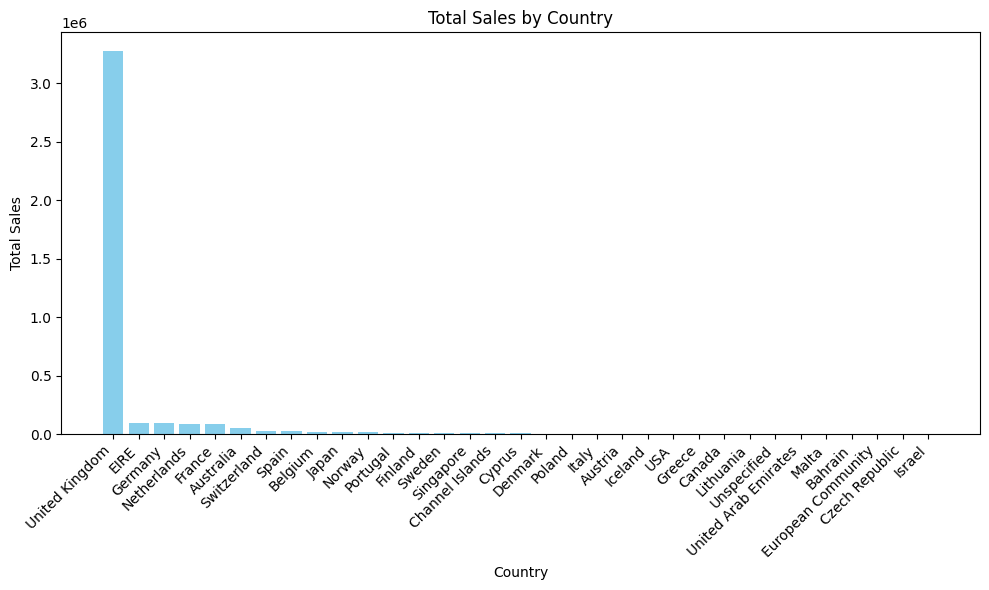

In [52]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the database
conn = sqlite3.connect('retail_dw.db')

# Run Roll-up query: Total sales by country
rollup_query = """
SELECT 
    c.Country,
    SUM(f.TotalSales) AS TotalSales
FROM SalesFact f
JOIN CustomerDim c ON f.CustomerID = c.CustomerID
GROUP BY c.Country
ORDER BY TotalSales DESC;
"""

rollup_df = pd.read_sql(rollup_query, conn)
conn.close()

# -------------------------------
# Visualization
# -------------------------------
plt.figure(figsize=(10,6))
plt.bar(rollup_df['Country'], rollup_df['TotalSales'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Total Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.tight_layout()

# Save figure as image
plt.savefig('total_sales_by_country.png', dpi=300)
plt.show()


Important information about sales performance across many product categories and geographical areas can be obtained from the retail data warehouse analysis. The Roll-up query allowed us to view total sales by nation. The graphic indicates a strong market presence and greater customer involvement as certain nations, like the UK, dominate sales data. Lower sales in a nation could indicate a new market or a region with little consumer activity, indicating chances for focused advertising or growth.

A thorough analysis of sales inside a particular nation was made possible by the drill-down query, which also identified high-performing products and monthly trends.  For instance, total sales peaked in some months, indicating either seasonal patterns or the impact of promotions.  By highlighting which product lines have a major impact on revenue, the Slice query for the Electronics category allowed for better data-driven decisions to be made about marketing and inventory.

By arranging transactional data into fact and dimension tables and facilitating quick querying and aggregation, the data warehouse aids in decision-making. Managers can examine sales at several levels, from high-level summaries to in-depth transactions, by using OLAP operations like roll-up, drill-down, and slice. Trend analysis, performance tracking, and strategic planning are made easier using this framework.

The insights show actual sales patterns because the dataset is real (online retail).  Because nations, goods, and amounts are randomly assigned, results from using synthetic data may not be realistic and could produce false conclusions.  Synthetic data, however, can be helpful for practicing analysis methods and testing ETL pipelines without disclosing private company information.


 All things considered, the retail data warehouse offers a strong foundation for deriving useful insights, comprehending market patterns, and assisting with well-informed choices regarding sales and marketing tactics.

In [ ]:
# Logging Queries
with open('olap_queries.sql', 'w') as f:
    f.write(rollup_query + "\n\n")
    f.write(drilldown_query + "\n\n")
    f.write(slice_query + "\n\n")